## Hyperparameter Optimization and Pipelines

### Summary

This tutorial demonstrates how to integrate quantum machine learning algorithms, specifically quantum kernel methods, from the `squlearn` library with traditional machine learning workflows in `scikit-learn`. We'll go through data generation, preprocessing, model definition, and hyperparameter optimization using GridSearchCV. The objective is to highlight that squlearn algorithms can be seamlessly used alongside classical algorithms.


### Importing Libraries

In this initial cell, we are importing all the libraries required for the tutorial. We are using `squlearn` for quantum kernel methods like Quantum Support Vector Regression (QSVR) and Quantum Gaussian Process Regression (QGPR). For tasks like data scaling and hyperparameter optimization, we rely on `scikit-learn`.


In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from squlearn import Executor
from squlearn.encoding_circuit import YZ_CX_EncodingCircuit
from squlearn.kernel.matrix import FidelityKernel, ProjectedQuantumKernel
from squlearn.kernel.ml import QGPR, QSVR

### Generating Data

Here, synthetic data is generated. We sample a training data set where we perform a grid search on. We also create hold-out test data which will be used to score the best estimator of the grid search.


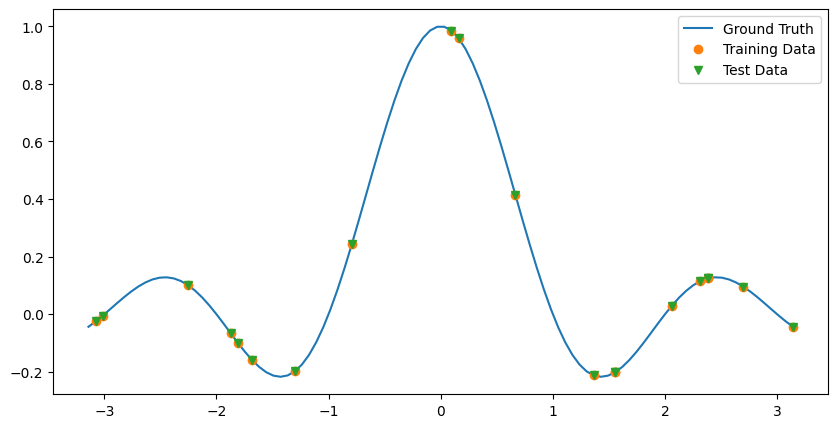

In [2]:
def generate_y(x):
    u = x * np.pi
    return np.sin(u) / u


np.random.seed(42)

# define training and test data
x = np.linspace(-np.pi, np.pi, 100)
y = generate_y(x)
x_train = np.random.choice(x, 20)
y_train = generate_y(x_train)

x_test = np.random.choice(x, 20)
y_test = generate_y(x_test)

plt.figure(figsize=(10, 5))
plt.plot(x, y, label="Ground Truth")
plt.plot(x_train, y_train, "o", label="Training Data")
plt.plot(x_train, y_train, "v", label="Test Data")
plt.legend()

### Setting up the kernels

We want to compare two QML algorithms with the same encoding circuit and two variants of calculating the kernel: Fidelity kernels and projected quantum kernels. We set up the encoding circuit with initial parameters. These will be varied during the grid search. The kernel instances are initialized using Qiskit's StatevectorSimulator.

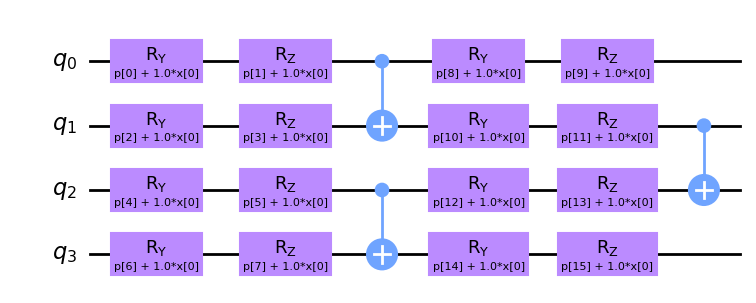

In [3]:
encoding_circuit = YZ_CX_EncodingCircuit(num_qubits=4, num_features=1, num_layers=2)

executor = Executor("statevector_simulator")

fidelity_kernel = FidelityKernel(
    encoding_circuit=encoding_circuit, executor=executor, parameter_seed=0
)
projected_kernel = ProjectedQuantumKernel(
    encoding_circuit=encoding_circuit, executor=executor, parameter_seed=0
)

encoding_circuit.draw("mpl")

### Setting up the grid search

In this section, we define the quantum kernel methods we'll be using for regression: Quantum Support Vector Regression (QSVR) and Quantum Gaussian Process Regression (QGPR). We initialize both with the two kernel-variants from above

We use `GridSearchCV` from `sklearn` to perform hyperparameter optimization. The hyperparameters include the number of qubits and layers for the quantum encoding circuits. 

In [4]:
num_qubit_list = [1, 2, 4]
num_layers_list = [1, 2, 3]

encoding_circuit_params = {
    "estimator__num_qubits": num_qubit_list,
    "estimator__num_layers": num_layers_list,
}

estimator_list = [
    QGPR(quantum_kernel=fidelity_kernel, full_regularization=False),
    QGPR(quantum_kernel=projected_kernel, full_regularization=False),
    QSVR(quantum_kernel=fidelity_kernel),
    QSVR(quantum_kernel=projected_kernel),
]

param_grid = []
for estimator in estimator_list:
    estimator_params = encoding_circuit_params.copy()
    estimator_params["estimator"] = [estimator]
    param_grid.append(estimator_params)

To scale the data, we use scikit-learns `StandardScaler`. This ensures that each feature has a mean of 0 and a standard deviation of 1, making it easier for the model to learn the optimal parameters. We create a pipeline with data scaling and the estimator to ensure that data scaling is part of the cross-validation process. We initialize the pipeline with an estimator. This will be overwritten in the grid search.

In [5]:
pipeline = Pipeline(
    [("scaler", StandardScaler()), ("estimator", QGPR(quantum_kernel=fidelity_kernel))]
)

### Running Grid Search

Now that everything is set up, we execute the grid search by fitting it to the training data. `GridSearchCV` will evaluate every combination of hyperparameters and choose the best set for each estimator (QSVR and QGPR in this case) based on the mean test score.


In [6]:
grid_search = GridSearchCV(pipeline, param_grid, scoring="neg_mean_squared_error")
grid_search.fit(x_train.reshape(-1, 1), y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('estimator',
                                        QGPR(quantum_kernel=<squlearn.kernel.matrix.fidelity_kernel.FidelityKernel object at 0x000001ED1BDA3AF0>))]),
             param_grid=[{'estimator': [QGPR(full_regularization=False,
                                             quantum_kernel=<squlearn.kernel.matrix.fidelity_kernel.FidelityKernel object at 0x000001ED1BDA3AF0>)],
                          'estimat...
                          'estimator__num_qubits': [1, 2, 4]},
                         {'estimator': [QSVR(C=1.0, cache_size=200, epsilon=0.1,
                                             max_iter=-1,
                                             quantum_kernel=<squlearn.kernel.matrix.projected_quantum_kernel.ProjectedQuantumKernel object at 0x000001ECB489ADC0>,
                                             shrinking=True, tol=0.001,
                                             verbose=False)],
                          'estimator__num_layers': [1, 2, 3],
                          'estimator__num_qubits': [1, 2, 4]}],
             scoring='neg_mean_squared_error')

### Results Analysis

To visualize the performance of different hyperparameter combinations, we plot heat maps for each estimator. Each cell in the heat map represents a combination of the number of qubits and layers used in the quantum encoding circuit, and the color represents the negative mean test score (MSE, larger is better). This allows for an intuitive understanding of how different hyperparameters impact performance.

C:\Users\mow\AppData\Local\Temp\ipykernel_24012\2408242799.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


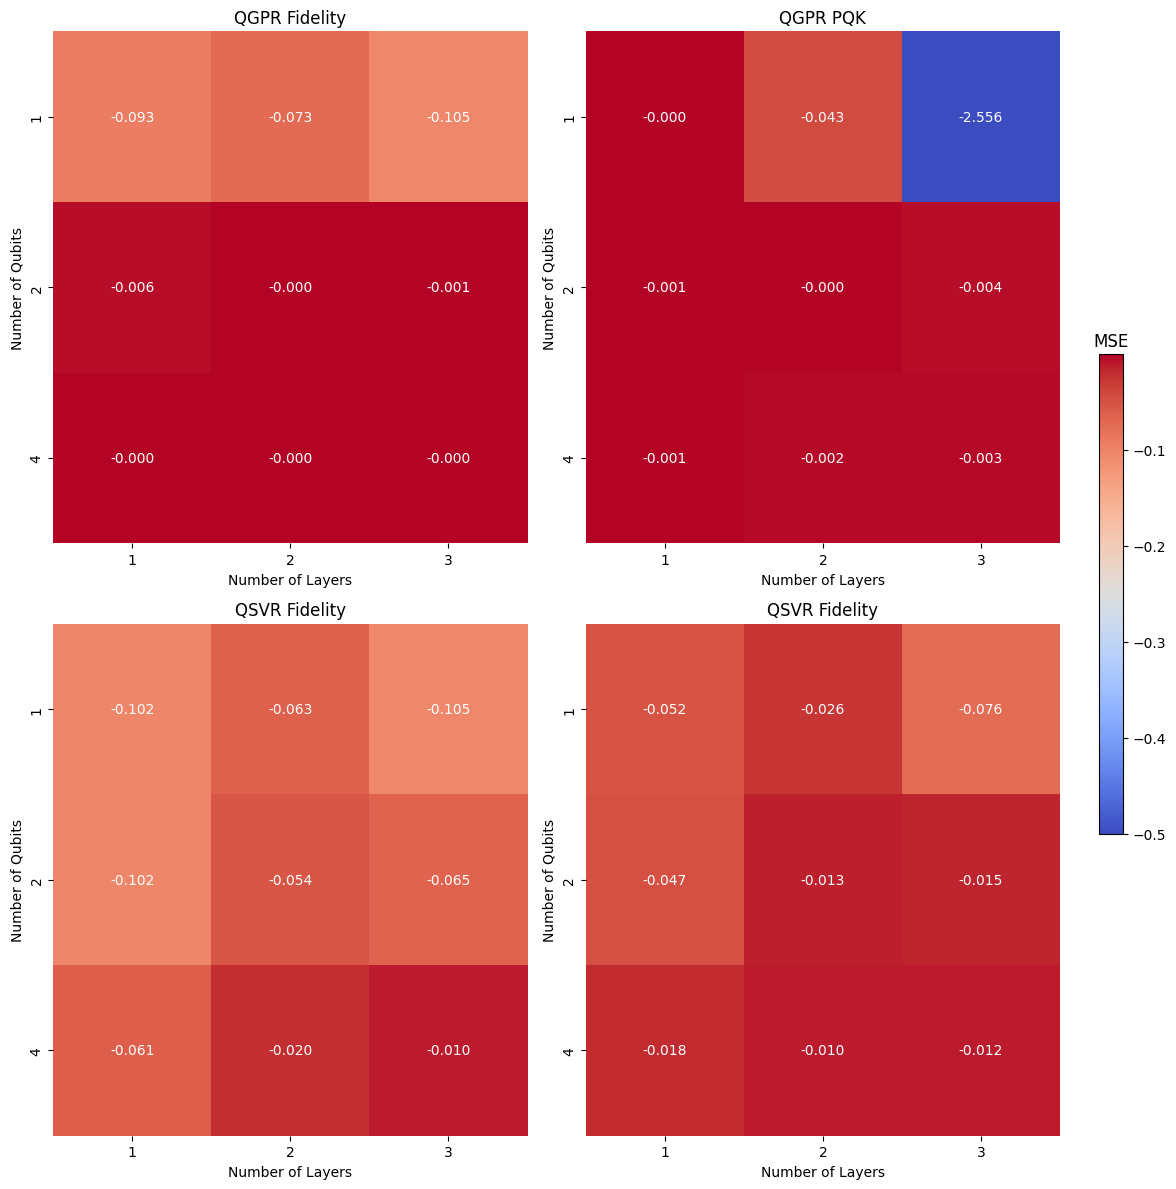

In [7]:
# Extract the results into a DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Number of unique combinations per estimator
num_combinations = len(num_qubit_list) * len(num_layers_list)

# Number of estimators
num_estimators = len(estimator_list)

# Initialize the grid for subplots
n_rows = int(np.ceil(np.sqrt(num_estimators)))
n_cols = int(np.ceil(num_estimators / n_rows))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 12))

# Flatten the axis array for easier indexing
if n_rows > 1 or n_cols > 1:
    axs = axs.flatten()

# Set min and max for the colormap
vmin = -0.5
vmax = results_df["mean_test_score"].max()

estimator_names = ["QGPR Fidelity", "QGPR PQK", "QSVR Fidelity", "QSVR Fidelity"]
# Loop through the chunks to plot each heat map
for i in range(num_estimators):
    start_idx = i * num_combinations
    end_idx = (i + 1) * num_combinations
    chunk_df = results_df.iloc[start_idx:end_idx]

    # Pivot to get a matrix form suitable for heat maps
    heat_map_data = chunk_df.pivot_table(
        index="param_estimator__num_qubits",
        columns="param_estimator__num_layers",
        values="mean_test_score",
    )

    # Create the heat map (cbar=False will disable individual colorbars)
    sns.heatmap(
        heat_map_data,
        annot=True,
        fmt=".3f",
        cmap="coolwarm",
        ax=axs[i],
        vmin=vmin,
        vmax=vmax,
        cbar=False,
    )
    axs[i].set_title(f"{estimator_names[i]}")
    axs[i].set_xlabel("Number of Layers")
    axs[i].set_ylabel("Number of Qubits")

# Add a colorbar with label
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
plt.colorbar(axs[-1].collections[0], cax=cbar_ax)
cbar_ax.set_title("MSE")

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

The best performing estimator is now evaluated on the test set and its predictions are shown alongside the generating data.

Test Score: 0.999999978217105


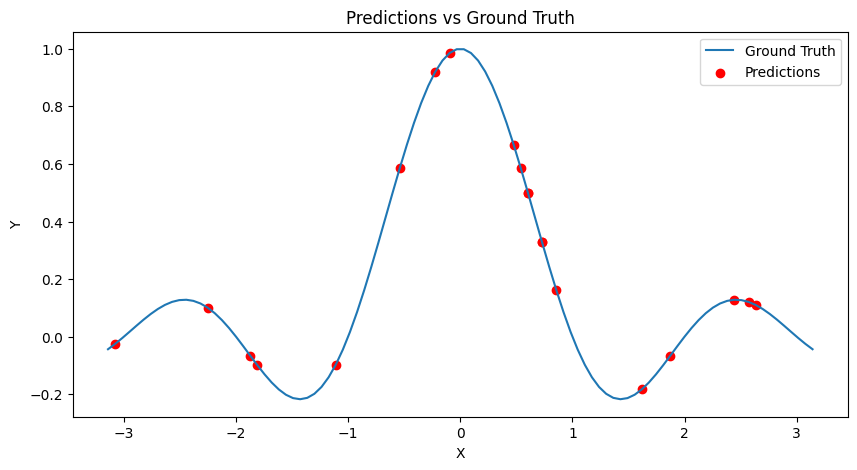

In [8]:
# Get the best estimator
best_estimator = grid_search.best_estimator_

# Score the best estimator on the test set
test_score = best_estimator.score(x_test.reshape(-1, 1), y_test)
print(f"Test Score: {test_score}")

# Make predictions on the test set
y_pred = best_estimator.predict(x_test.reshape(-1, 1))

# Plot the predictions and ground truth
plt.figure(figsize=(10, 5))
plt.plot(x, y, label="Ground Truth")
plt.scatter(x_test, y_pred, c="red", label="Predictions")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Predictions vs Ground Truth")
plt.legend()
plt.show()

Note that in the above evaluation, the QSVR did not perform quite as good as the QGPR. The QSVR is, as its classical counterpart, sensitive to additional hyperparameters which have not been varied during the grid search. We now include the classical regularization parameter C and the slack variable epsilon as additional parameters in the search. This also demonstrates that parameters of the quantum kernel and parameters of the classical algorithm can be treated equally during the search.

In [9]:
QSVR(quantum_kernel=fidelity_kernel)

estimator_params = encoding_circuit_params.copy()
estimator_params["estimator"] = [QSVR(quantum_kernel=fidelity_kernel)]
estimator_params["estimator__C"] = [1e0, 1e1, 1e2]
estimator_params["estimator__epsilon"] = [1e-4, 1e-3, 1e-2]
param_grid = estimator_params

grid_search = GridSearchCV(pipeline, param_grid, scoring="neg_mean_squared_error")
grid_search.fit(x_train.reshape(-1, 1), y_train)

print(f"Best Score: {grid_search.best_score_}")
print(f"Best Estimator: {grid_search.best_estimator_}")

Best Score: -3.0204753114345332e-05
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('estimator',
                 QSVR(C=100.0, cache_size=200, epsilon=0.0001, max_iter=-1,
                      quantum_kernel=<squlearn.kernel.matrix.fidelity_kernel.FidelityKernel object at 0x000001ED1F382970>,
                      shrinking=True, tol=0.001, verbose=False))])


With these more adequate classical hyperparameters, the QSVR performs similarly to the QGPR.